# AirBnB Data Correaltions

This code aims to look at the correlation between different variables in the AirBnB dataset.

## Full Documentation of Results

#### Loading and Cleaning Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Importing the google sheet into our notebook

doc_id = "1ecopK6oyyb4d_7-QLrCr8YlgFrCetHU7-VQfnYej7JY"
sheet_names = ["amsterdam_weekdays", "amsterdam_weekends", "athens_weekdays", "athens_weekends", "berlin_weekends", 
               "barcelona_weekdays", "barcelona_weekends", "berlin_weekdays", "budapest_weekdays", 
               "budapest_weekends", "lisbon_weekdays", "lisbon_weekends", "london_weekdays", 
               "london_weekends", "paris_weekdays", "paris_weekends", "rome_weekdays", 
               "rome_weekends", "vienna_weekdays", "vienna_weekends"]
city_country_map = {
    "amsterdam": "Netherlands",
    "athens": "Greece",
    "berlin": "Germany",
    "barcelona": "Spain",
    "budapest": "Hungary",
    "lisbon": "Portugal",
    "london": "United Kingdom",
    "paris": "France",
    "rome": "Italy",
    "vienna": "Austria"
}
dataframes = []
for sheet_name in sheet_names:
    url = f"https://docs.google.com/spreadsheets/d/{doc_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
    df = pd.read_csv(url)
    city, day_type = sheet_name.split("_")
    df['City'] = city.capitalize()  
    df['Country'] = city_country_map.get(city, "Unknown")  
    df['DayType'] = "Weekday" if day_type == "weekdays" else "Weekend"
    dataframes.append(df)

In [3]:
# Combinging the seperate sheets into one dataframe table 
combined_df = pd.concat(dataframes, ignore_index=True)
combined_df.to_csv("asda_homework.csv", index=False)

# Renaming the realSum column to 'Price'
combined_df = combined_df.rename(columns={'realSum': 'Price'})

# Dropping the index column
combined_df = combined_df.drop(columns=['Unnamed: 0'])
combined_df.head(1)

,Price,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,...,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat,City,Country,DayType
0,194.033698,Private room,False,True,2,False,1,0,10,93,...,2.53938,78.690379,4.166708,98.253896,6.846473,4.90569,52.41772,Amsterdam,Netherlands,Weekday


In [4]:
combined_df['no_of_listings'] = combined_df.apply(lambda row: '1' if row['multi'] == 0 and row['biz'] == 0 
    else '2-4' if row['multi'] == 1 and row['biz'] == 0 
    else '>4' if row['multi'] == 0 and row['biz'] == 1 
    else 'unknown', axis=1)
combined_df = combined_df.drop(columns=['multi', 'biz'])
column_order = list(combined_df.columns)
insert_position = column_order.index('host_is_superhost') + 1  # Position after 'host_is_superhost'
column_order.insert(insert_position, column_order.pop(column_order.index('no_of_listings'))) # The place of column will be same as multi & biz
combined_df = combined_df[column_order]
combined_df.head(3)

,Price,room_type,room_shared,room_private,person_capacity,host_is_superhost,no_of_listings,cleanliness_rating,guest_satisfaction_overall,bedrooms,...,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat,City,Country,DayType
0,194.033698,Private room,False,True,2,False,2-4,10,93,1,...,2.539380,78.690379,4.166708,98.253896,6.846473,4.90569,52.41772,Amsterdam,Netherlands,Weekday
1,344.245776,Private room,False,True,4,False,1,8,85,1,...,0.239404,631.176378,33.421209,837.280757,58.342928,4.90005,52.37432,Amsterdam,Netherlands,Weekday
2,264.101422,Private room,False,True,2,False,>4,9,87,1,...,3.651621,75.275877,3.985908,95.386955,6.646700,4.97512,52.36103,Amsterdam,Netherlands,Weekday


#### Inspecting the Data

As we are interesting in testing correlation, we need to check two assumptions about the data:
1. Is data normally distributed?
2. How many datapoints do we have?

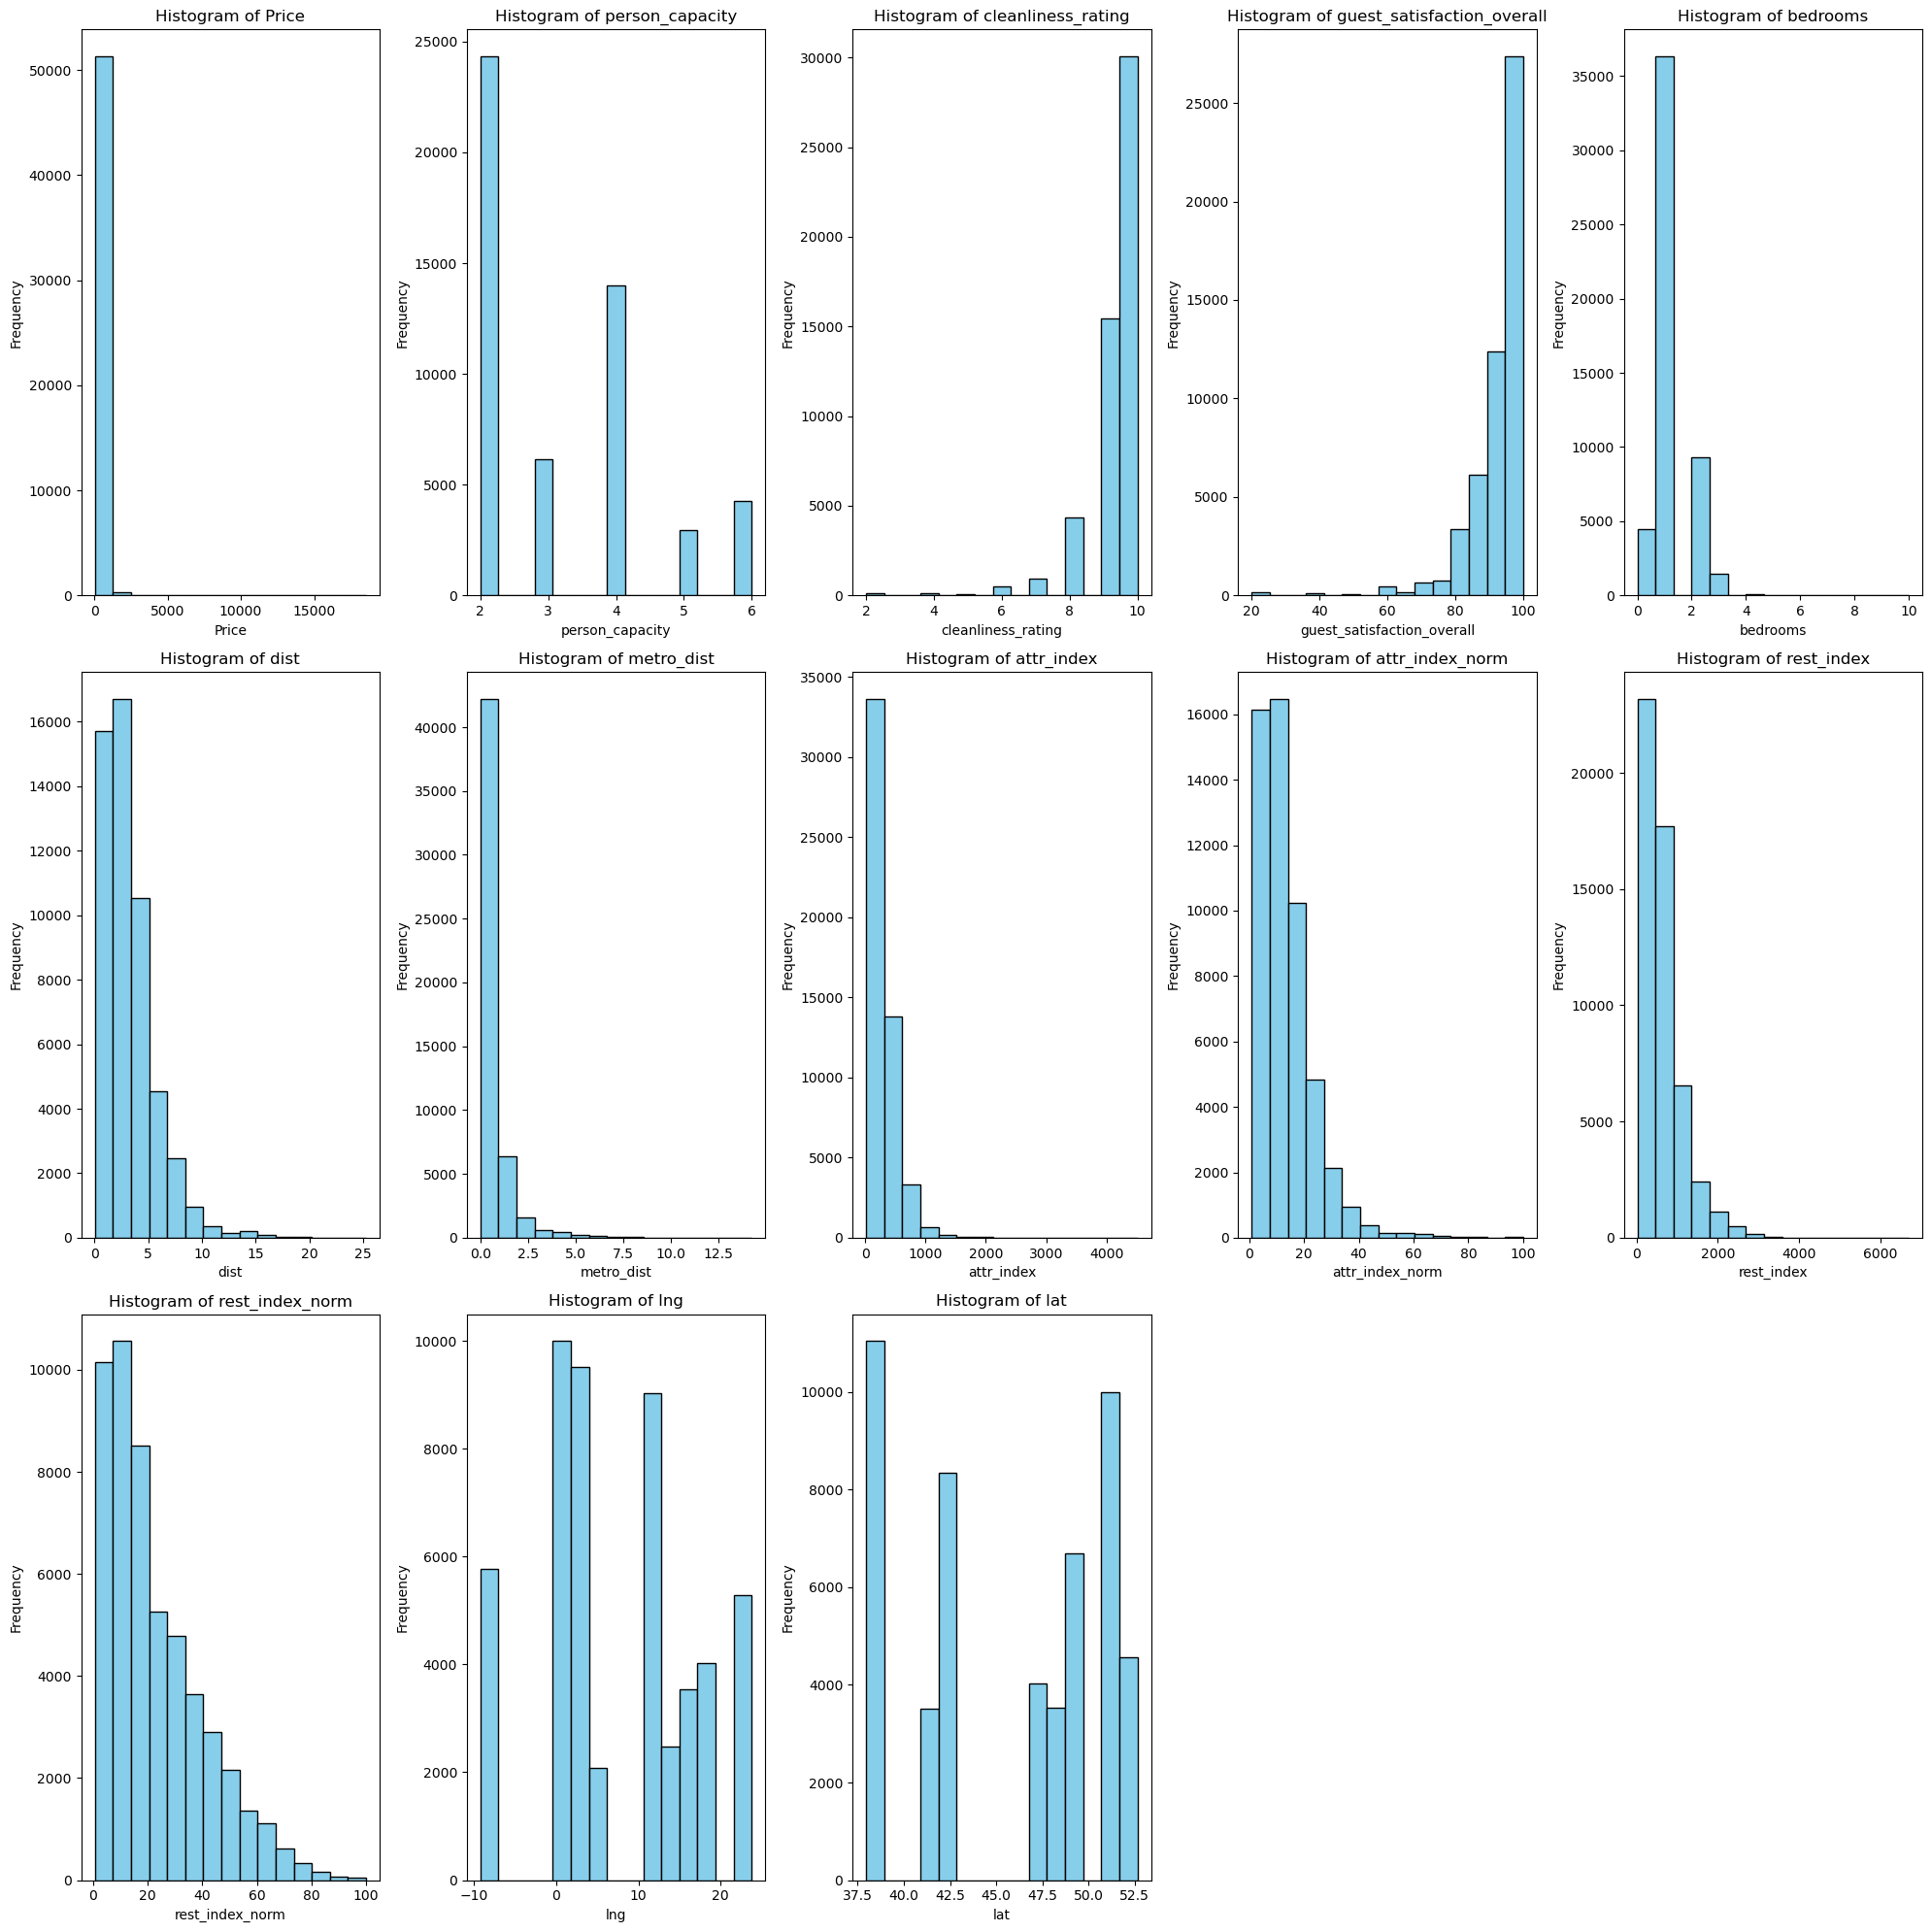

In [5]:
# Checking if the data is normally distributed
numeric_data = combined_df.select_dtypes(include=['float64', 'int64'])

# Set up the figure for subplots
num_columns = len(numeric_data.columns)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20, 20))

axes = axes.flatten()

# Loop through each column and plot a histogram
for i, column in enumerate(numeric_data.columns):
    axes[i].hist(numeric_data[column], bins=15, color='skyblue', edgecolor='black')
    axes[i].set_title(f'Histogram of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

for j in range(i + 1, len(axes.flatten())):
    axes.flatten()[j].axis('off')

# Adjust layout to make sure labels are readable
plt.tight_layout()
plt.show()


Most of the data is not clearly normally distributed, so we will use Spearman's Test for correlation. This test doesn't perform well on small datasets, so we will check the size of the dataset.

In [6]:
rows, columns = combined_df.shape
print(f"Rows: {rows}, Columns: {columns}")

Rows: 51707, Columns: 21


With over 51,000 rows, the dataset should be large enough for Spearman's test.

#### Calculating Correlation

In [7]:
# Calculate correlation with the new numeric column
correlation_matrix = numeric_data.corr(method='pearson')


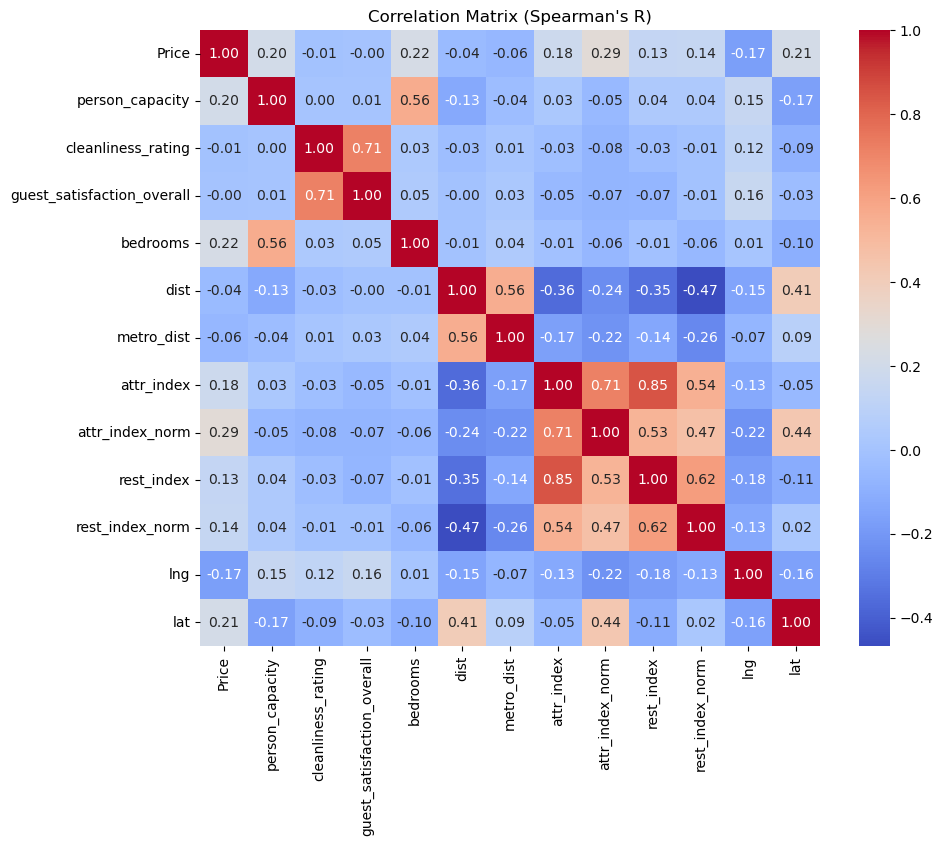

In [8]:
# Visualize the updated correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix (Spearman's R)")
plt.show()

Looking at this heatmap, we ca see that there are some correlations that make less sense to consider e.g. the link between attr_index and attr_index_norm, as they are clearly linked. However, some, such as the link between cleanliness and guest satisfaction rating, may be of interest. Therefore, before we pairplot, we will reduce the which variables we consider. 

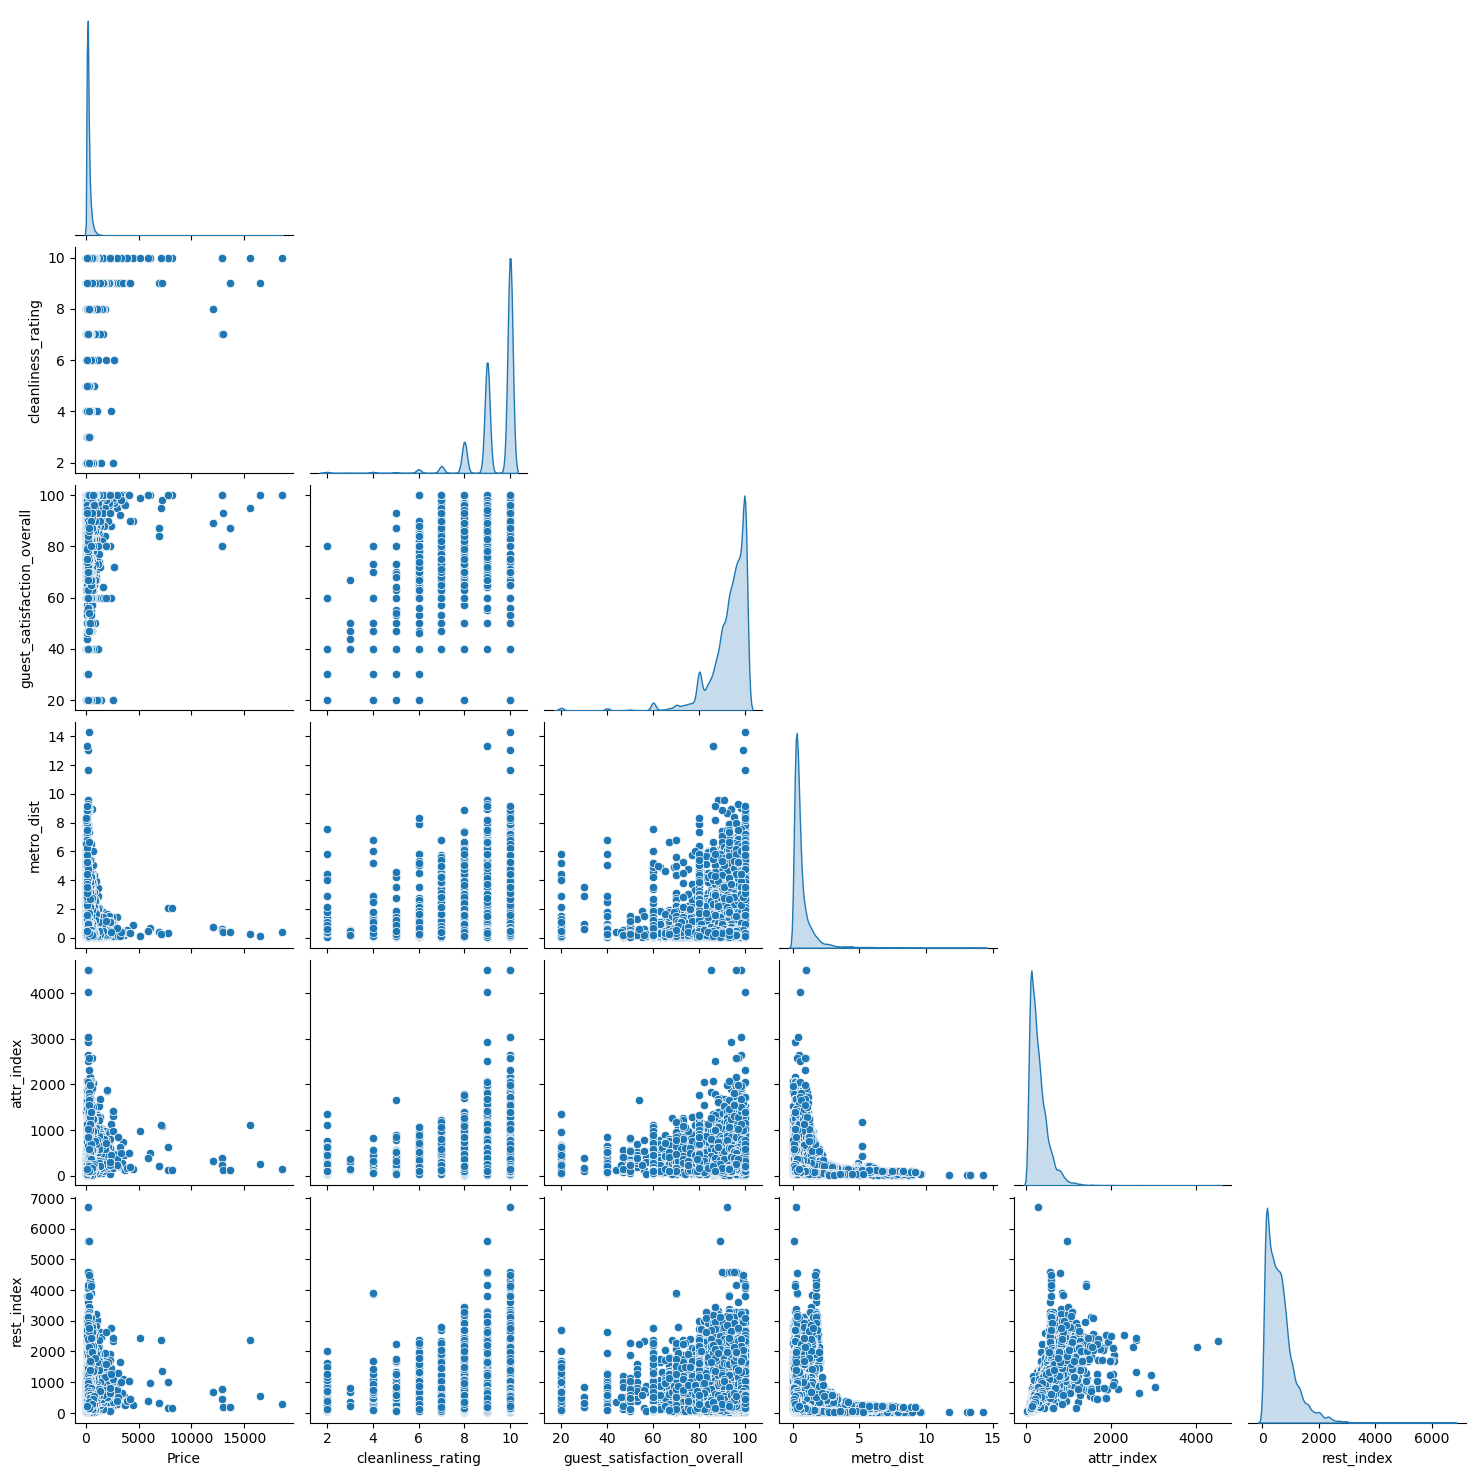

In [9]:
# Select columns to include in the pair plot
selected_columns = ['Price', 'cleanliness_rating', 'guest_satisfaction_overall', 'metro_dist', 'attr_index', 'rest_index']

# Basic pair plot
sns.pairplot(combined_df[selected_columns], diag_kind='kde', corner=True)

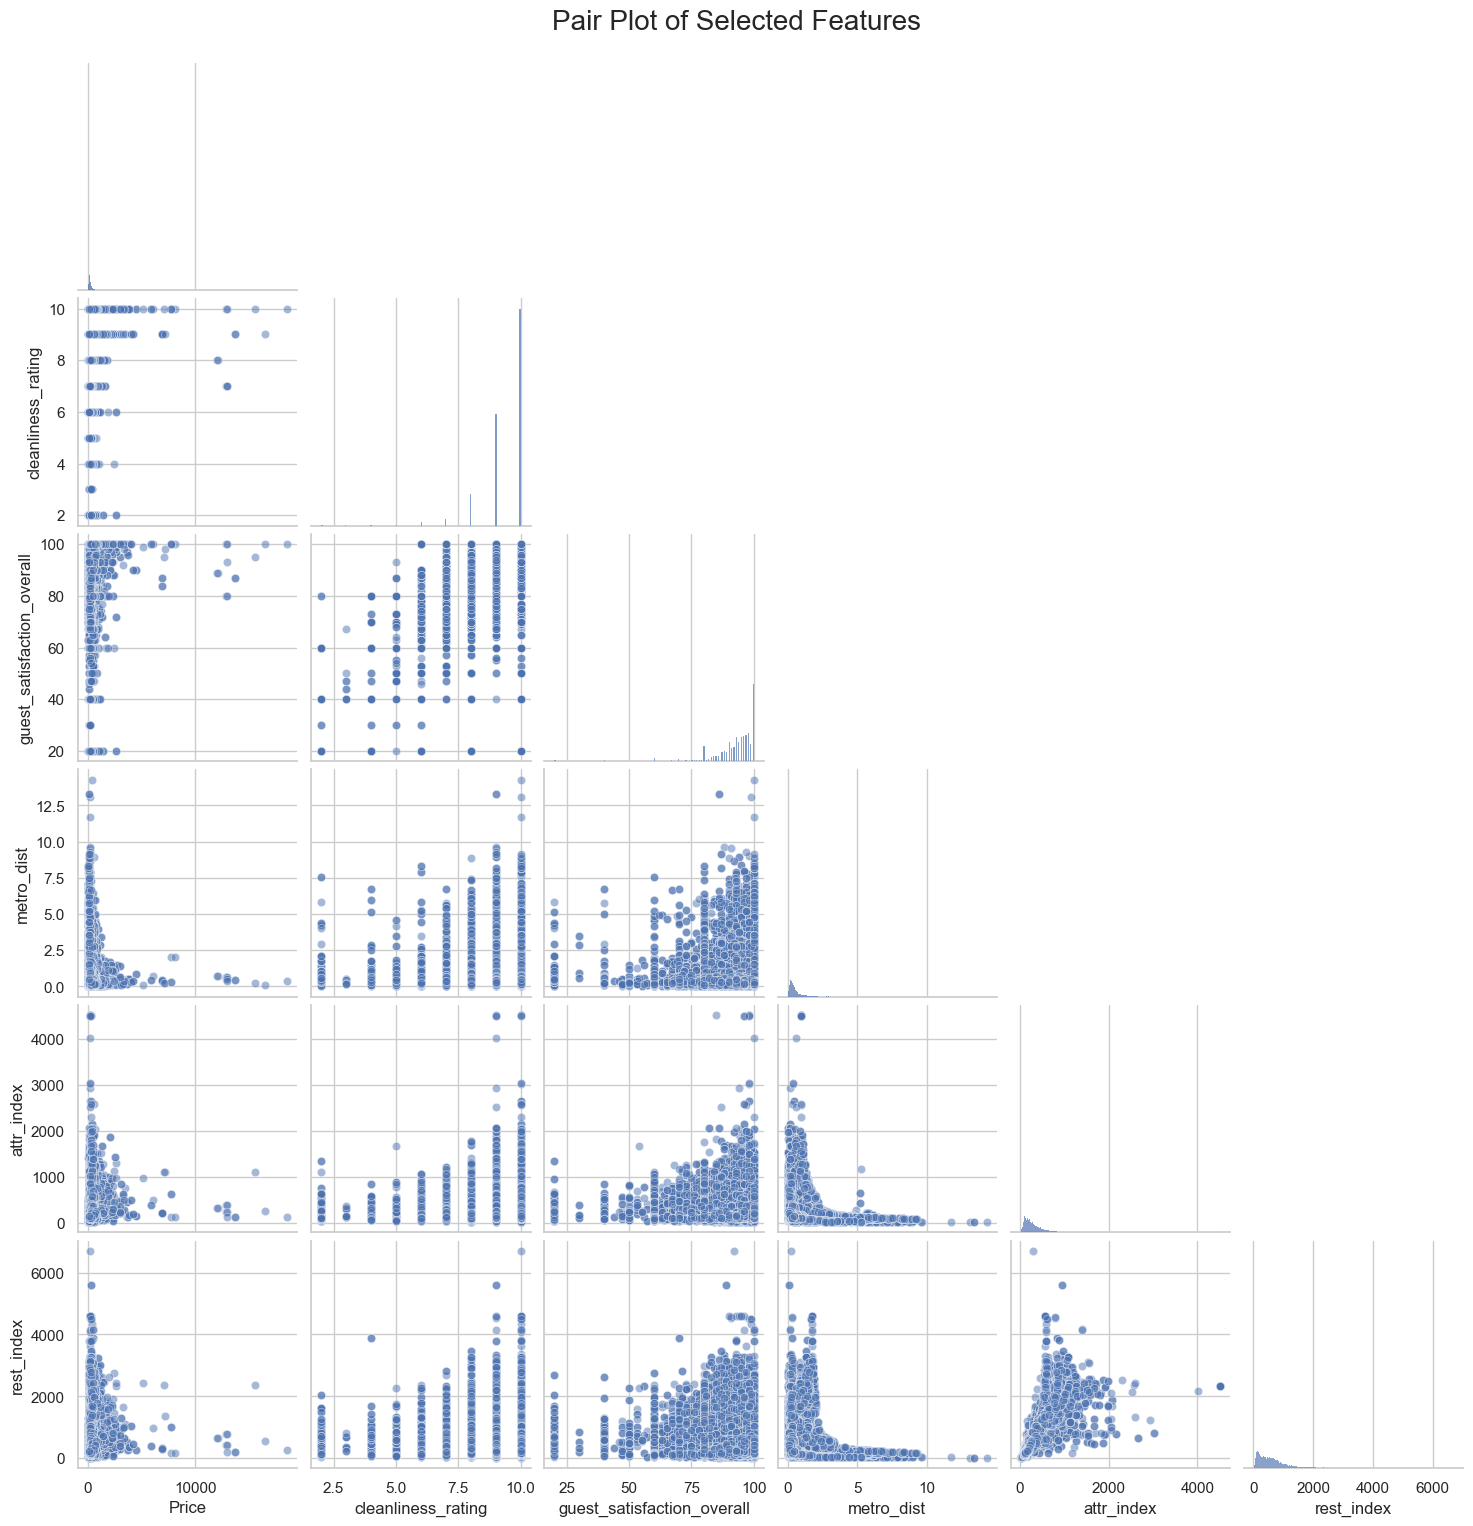

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select columns to include in the pair plot
selected_columns = ['Price', 'cleanliness_rating', 'guest_satisfaction_overall', 'metro_dist', 'attr_index', 'rest_index']

# Set plot style
sns.set(style="whitegrid")

# Create a pairplot with improvements
sns.pairplot(
    combined_df[selected_columns], 
    diag_kind='hist',   # Diagonal plot type: 'kde' (Kernel Density Estimation)
    corner=True,       # Remove upper triangle for clarity 
    plot_kws={'alpha': 0.5},  # Set transparency for scatter plots
)

# Optionally add a title
plt.suptitle('Pair Plot of Selected Features', size=20, y=1.02)

# Show the plot
plt.show()


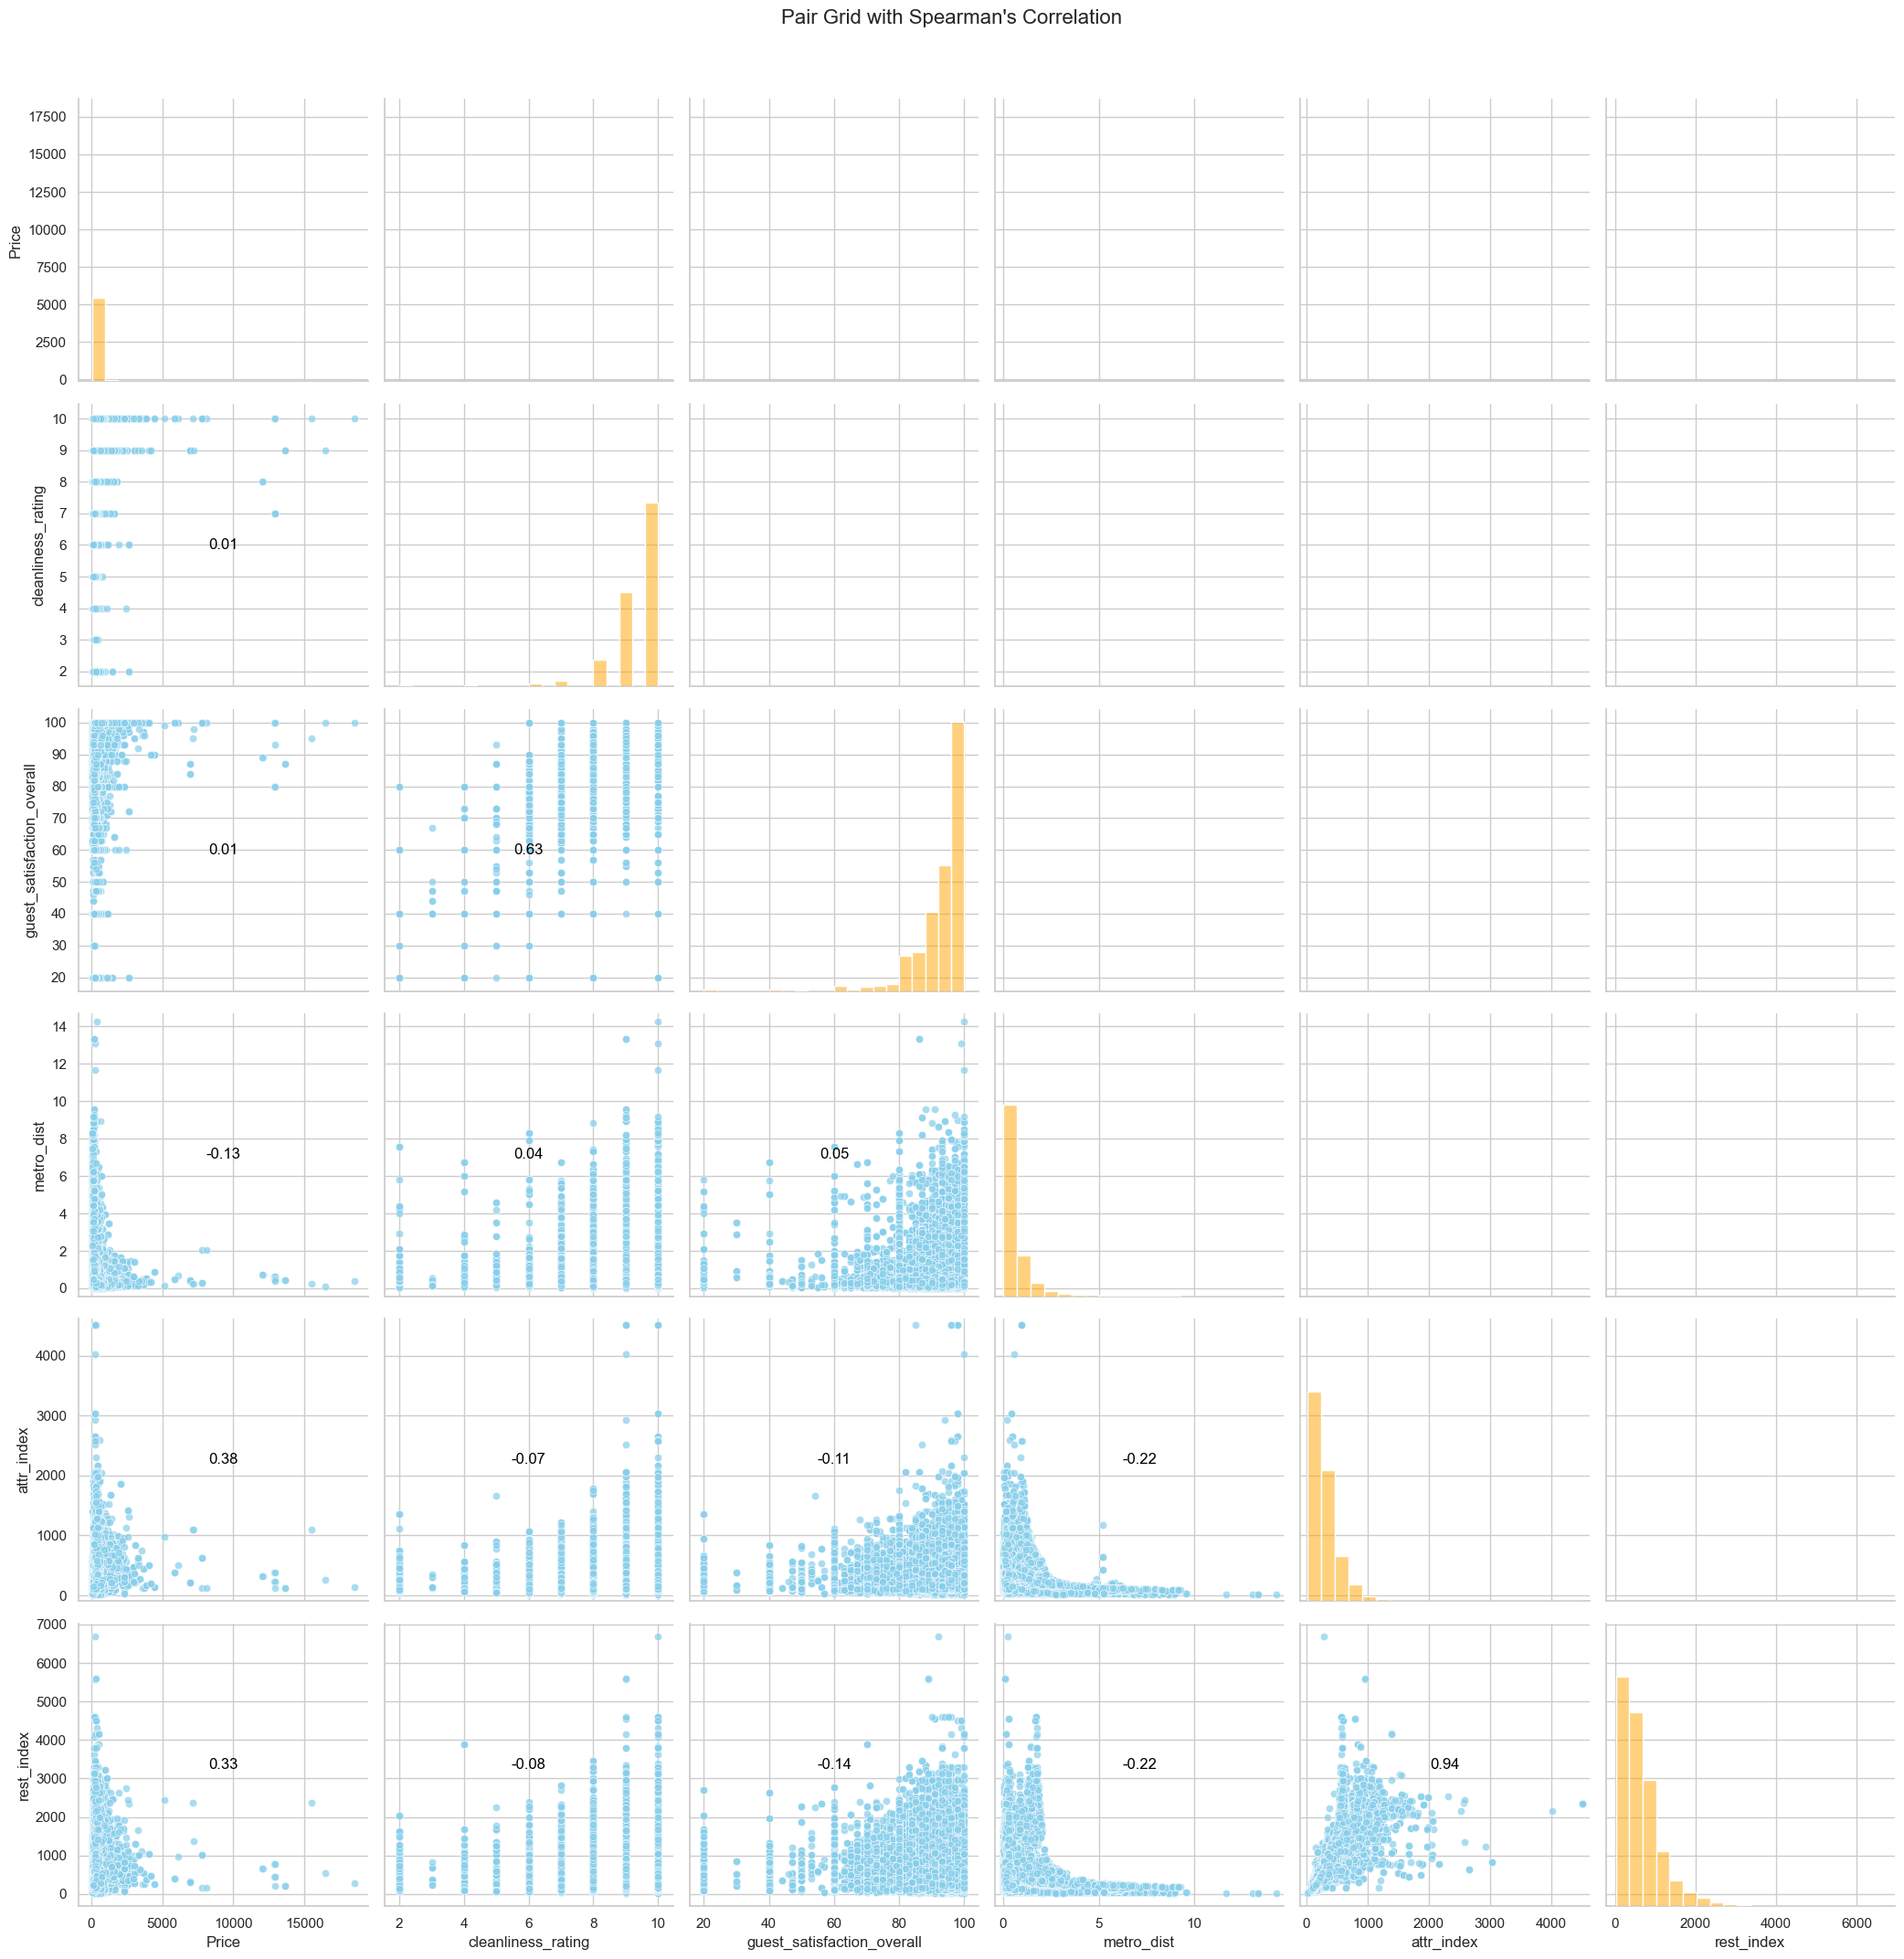

In [13]:
selected_columns = ['Price', 'cleanliness_rating', 'guest_satisfaction_overall', 'metro_dist', 'attr_index', 'rest_index']

# Calculate Spearman's correlation matrix
spearman_corr = combined_df[selected_columns].corr(method='spearman')

# Create a custom function to annotate the upper triangle with Spearman's correlation
def corr_func(x, y, **kwargs):
    corr = np.corrcoef(x, y)[0, 1]
    # Return Spearman's correlation rounded to 2 decimal places
    return f"{corr:.2f}"

# Create the PairGrid object
g = sns.PairGrid(combined_df[selected_columns], height=3.5, diag_sharey=False)

# Map the scatter plots (lower triangle)
g.map_lower(sns.scatterplot, alpha=0.7, color='skyblue')

# Map the diagonal histograms
g.map_diag(sns.histplot, kde=True, color='orange', bins=20,line_kws={'linewidth': 0})

# Map the upper triangle with the correlation coefficients
g.map_upper(sns.kdeplot, cmap="Blues", alpha=0)  # Empty kdeplot for spacing

for i, j in zip(*np.tril_indices_from(spearman_corr, -1)):
    g.axes[i, j].annotate(f'{spearman_corr.iloc[i, j]:.2f}', 
                          xy=(0.5, 0.5), xycoords='axes fraction', 
                          ha='center', va='center', fontsize=12, color='black')

# Add title
g.fig.suptitle('Pair Grid with Spearman\'s Correlation', size=16, y=1.02)



# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()